In [1]:
import scipy
import theano

import numpy as np
import matplotlib.pyplot as plt

import keras.engine  as KE
import keras.backend as K

from keras import models
from keras import optimizers
from keras import regularizers
from keras import layers
from keras import utils
from keras import metrics
from keras import activations

from complexnn.conv        import ComplexConv1D, ConvFB
from complexnn.utils       import *
from complexnn.loss        import *
from complexnn.activations import *
from complexnn.models      import *

from datasets.chirp import complex_chirp
from datasets.utils import *

from sklearn.model_selection import train_test_split

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using Theano backend.


In [2]:
%load_ext autoreload
%autoreload 2

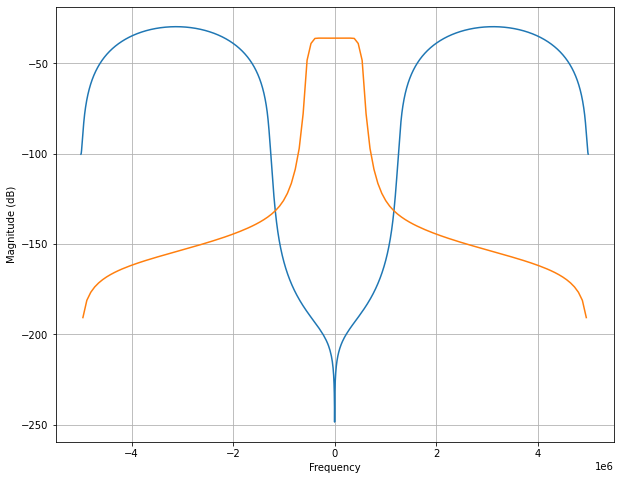

In [3]:
Fs = 10E6
t = np.linspace(0, 0.001, int(0.001 * Fs))
s = complex_chirp(t, Fs/8, t[-1], Fs/4 + Fs/4) + complex_chirp(t, -Fs/8, t[-1], -(Fs/4 + Fs/4))
w = scipy.signal.firwin(numtaps=129, cutoff=0.1, pass_zero="lowpass", window='kaiser', width=0.001)

plt.figure(figsize=(10, 8))
plt.magnitude_spectrum(s, Fs=Fs, scale='dB')
plt.magnitude_spectrum(w, scale='dB', sides='twosided', Fs=Fs)
plt.grid(True)
plt.show()

In [4]:
signal   = layers.Input(shape=(s.shape[0], 2))
filtered = ConvFB(filters=4, kernel_size=10)(signal)

model = models.Model(inputs=signal, outputs=filtered)

S = tochanneled(s).reshape(1, s.shape[0], 2)
X = model.call(S).eval()

In [5]:
X.shape

(1, 10000, 8)

In [6]:
def k_real_conv(s, f):
    cargs = {"strides"       : 1,
             "padding"       : "causal",
             "data_format"   : "channels_last",
             "dilation_rate" : 1}
    S = K.variable(s.reshape(1, s.shape[0], 1))
    F = K.variable(f.reshape(f.shape[0], 1, f.shape[1]))
    return K.conv1d(S, F, **cargs)

def k_complex_conv(s, f):
    shape = (s.shape[0], 1 if (len(f.shape) == 1) else f.shape[1])
    
    S = tochanneled(s)
    F = tochanneled_m(f)
    
    sr, si = S[:, 0], S[:, 1]
    fr, fi = F[:, : shape[1]], F[:, shape[1] :]
    
    cr = k_real_conv(sr, fr) - k_real_conv(si, fi)
    ci = k_real_conv(sr, fi) + k_real_conv(si, fr)
    
    return (cr + 1j * ci).eval().reshape(shape)

def np_convolve(s, f):
    return scipy.signal.convolve(s, f, mode="full")[:-f.shape[0] + 1]

def fb_conv(s, w, num=2):
    fs = np.linspace(0, 2 * np.pi, num, endpoint=False)
    n = np.arange(0, w.shape[0])
    E = np.zeros(shape=(w.shape[0], fs.shape[0]), dtype=np.complex64)
    for f in range(fs.shape[0]):
        E[:, f] = np.exp(1j * fs[f] * n)
    return w.reshape(w.shape[0], 1) * E

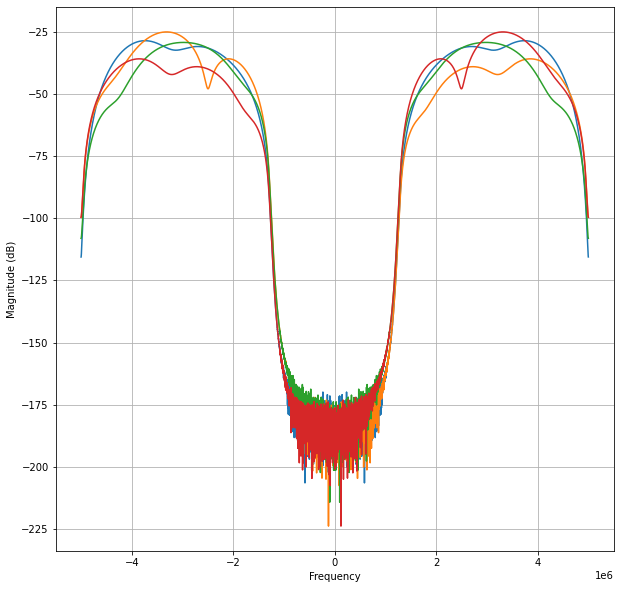

In [7]:
W = fb_conv(1, w, num=4)
plt.figure(figsize=(10, 10))
for f in range(4):
    plt.magnitude_spectrum(X[0, :, f] + 1j * X[0, :, 4 + f], scale='dB', Fs=Fs)
plt.grid(True)
plt.show()

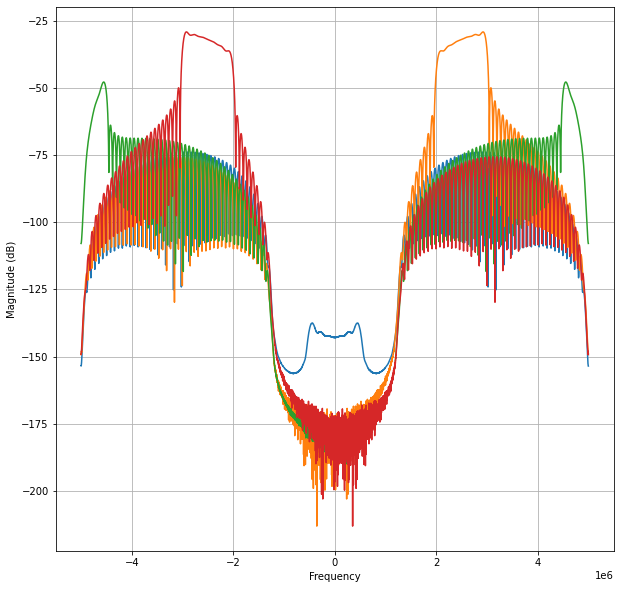

In [8]:
R = k_complex_conv(s, W)
plt.figure(figsize=(10, 10))
for f in range(R.shape[1]):
    plt.magnitude_spectrum(R[:, f], scale='dB', Fs=Fs)
plt.grid(True)
plt.show()